In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import zipfile
import io
import json
import os, sys
from glob import glob
import numpy as np
from urllib.request import urlopen
from rasterio.io import ZipMemoryFile
import ee
import secret
import rasterio
import matplotlib.pyplot as plt
import random
import math
parentdir = os.path.split(os.getcwd())[0]
sys.path.append(parentdir)
from utils import load_numpy, get_rand_patch, read_tfrecord, getLabelsForTIF, get_rand_patches_1pp
from tf_records_generator import CenterPixelTarget, ImageSegmentation, _bytes_feature, _int64_feature, serialize_data
import tensorflow as tf
from rasterio.errors import RasterioIOError
ee.Initialize(ee.ServiceAccountCredentials(secret.EE_ACCOUNT, secret.EE_PRIVATE_KEY_FILE))

glob("../data/basemap/003_1_Basemap.tif")[0]

2 Physical GPUs, 2 Logical GPUs


'../data/basemap/003_1_Basemap.tif'

## Initialize ImageCollection

In [31]:
def get_regions(geojson):
    regions = []
    with open(geojson) as f:
        data = json.loads(f.read())
        for feat in data["features"]:
            regions.append(ee.Geometry(feat["geometry"]))
        return regions
    
geojson = glob("data/003_1.geojson")[0]
file_name = os.path.basename(geojson).split(".")[0]
print("Getting regions for: {}".format(file_name))
regions = get_regions(geojson)

Getting regions for: 003_1


In [4]:
def maskImage(image):
    """Mask that is adviced by Google Earth's Sentinel-1 coverage"""
    edge = image.lt(-30.0)
    maskedImage = image.mask().And(edge.Not())
    return image.updateMask(maskedImage)

def mapTimes(img):
    return ee.Image(img).date().format()

# First bound filter used to filter dates
boundsFilter = ee.Filter.geometry(ee.Geometry(regions[0]))

sentinel1_example_img = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filter(boundsFilter) \
        .filter(timeFilter) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
# if it contains VH, it also contains VV
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \ 
        .map(maskImage)

s1_borneo = ee.ImageCollection('COPERNICUS/S1_GRD')\
        .filter(boundsFilter) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        # if it contains VH, it also contains VV
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
        .map(maskImage)

# Save times for borneo image to use when downloading
times = ee.List(s1_borneo.toList(s1_borneo.size())).map(mapTimes).getInfo()


NameError: name 'boundsFilter' is not defined

## Store file in Google Cloud Storage

In [ ]:
def store_on_gcs(geom, image, name):
    task = ee.batch.Export.image.toCloudStorage(
      image=image,
      description='imageToCloud',
      bucket='ews-data',
      fileNamePrefix=name,
      scale=15,
      region=geom
    )
    task.start()

# Complete S1 image (whole world)
s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    # if it contains VH, it also contains VV
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .map(maskImage)
    
# Download files for all available S1 times
def store_all_regions(regions, location)
    times = get_times_for_collection(s1_collection)
    for time in times:
        image = s1_collection.filter(ee.Filter.date(ee.Date(time), ee.Date(time)))
        for i, region in regions:
            region = ee.Geometry(region)
            store_on_gcs(region, image, "/data/{}/{}/{}".format(location, time, i))

### Download Satellite images from Google Storage

In [ ]:
from google.cloud import storage
parentdir = os.path.split(os.getcwd())[0]
sys.path.append(parentdir)
from utils import create_folder
storage_client = storage.Client.from_service_account_json('privatekey.json')

In [ ]:
# Note: Client.list_blobs requires at least package version 1.17.0.
blobs = storage_client.list_blobs(
    "ews-data", prefix="data/"
)

print("Blobs:")
for blob in blobs:
    print(blob.name)
    create_folder(blob.name[0:blob.name.rindex("/")])
    # Re-enable to actually download the data
    #blob.download_to_filename(blob.name)

## Inspect Downloaded TIFs

In [5]:
files = glob("data/003_1/**/*.tif", recursive=True)
latest = glob("data/003_1/2020_02_12/*.tif")

In [ ]:
# Average days between two dates of images
from datetime import datetime

def get_date_string(f):
    return f.split("/")[2]

def get_date(d):
    return datetime.strptime(d, "%Y_%m_%d")

dates = sorted(set([get_date_string(f) for f in files]))
dates = [get_date(d) for d in dates]
differences = []
for i, d in enumerate(dates):
    if i == len(dates) - 1:
        break
    dif = dates[i + 1] - d
    differences.append(dif.days)

np.mean(differences)

### Calculate min max

In [ ]:
### DONT RUN, TAKES REALLY LONG

total_max = 0
total_min = 0
for f in files:
    try:
        vh_vv = rasterio.open(f).read()[0:2, :, :]
        max_in_rast = np.nanmax(vh_vv)
        total_max = np.nanmax([total_max, max_in_rast])
        min_in_rast = np.nanmin(vh_vv)
        total_min = np.nanmin([total_min, min_in_rast])
    except RasterioIOError as e:
        print(e)
print(total_min, total_max)

## Inspect latest files of 003_1

In [ ]:
def norm_img(img):
    """This function assumes that 3rd channel is angel 
    Which needs to be converted to VV/VH for displaying purposes"""
    img = img.copy()
    img[:, :, 2] = img[:, :, 0] / img[:, :, 1]
    min = np.nanmin(img[:,:,2])
    max = np.nanmax(img[:,:,2])
    # Normalize
    img[:, :, 2] = (img[:, :, 2] - min) / (max - min)
    img[:, :, [0, 1]] = (img[:, :, [0, 1]] - - 30) / (40.3 - -30)
    return img

In [11]:
x, y = load_numpy(latest[0], 3)

In [ ]:
y

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.imshow(norm_img(x))


_ = plt.hist(y.flatten(), bins='auto')  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")
# Text(0.5, 1.0, "Histogram with 'auto' bins")

plt.show()

In [6]:
for file in latest:
    x, y = load_numpy(file, 3)
    n_labels = y.shape[0] * y.shape[1]
    n_pixels = x.shape[0] * x.shape[1] * x.shape[2]
    zeros_pixels = np.count_nonzero(np.isnan(x))
    perc_pixels = round(zeros_pixels/n_pixels*100, 3)
    print("IMG nans: {}%".format(perc_pixels))
    zeros_labels = np.count_nonzero(y)
    perc_labels = round(zeros_labels/n_labels*100, 3)
    print("labels 1's: {}%".format(perc_labels))

IMG nans: 0.127%
labels 1's: 7.328%
IMG nans: 0.064%
labels 1's: 12.542%
IMG nans: 0.014%
labels 1's: 18.206%
IMG nans: 0.014%
labels 1's: 7.158%
IMG nans: 0.051%
labels 1's: 3.982%
IMG nans: 0.06%
labels 1's: 16.46%
IMG nans: 0.001%
labels 1's: 10.09%
IMG nans: 0.053%
labels 1's: 8.708%
IMG nans: 0.029%
labels 1's: 8.407%
IMG nans: 2.593%
labels 1's: 18.961%
IMG nans: 0.007%
labels 1's: 4.553%
IMG nans: 0.001%
labels 1's: 24.304%
IMG nans: 0.062%
labels 1's: 1.791%
IMG nans: 0.047%
labels 1's: 22.226%


In [7]:
for file in latest:
    img, _ = load_numpy(file, 3)
    nans = np.count_nonzero(np.isnan(img))
    print("{}: Nans: {} ({}%)".format(file, nans, (nans/img.size*100)))
# We can see that most nans are in region 2 in 003_1

data/003_1/2020_02_12/8.tif: Nans: 18401 (0.1266439243057365%)
data/003_1/2020_02_12/13.tif: Nans: 6266 (0.06355732777647945%)
data/003_1/2020_02_12/1.tif: Nans: 506 (0.014070399827373434%)
data/003_1/2020_02_12/7.tif: Nans: 2094 (0.013765509864230264%)
data/003_1/2020_02_12/0.tif: Nans: 6511 (0.05107850486132276%)
data/003_1/2020_02_12/5.tif: Nans: 9167 (0.06009374676939571%)
data/003_1/2020_02_12/6.tif: Nans: 77 (0.0005971030730181063%)
data/003_1/2020_02_12/3.tif: Nans: 6245 (0.05312299858358519%)
data/003_1/2020_02_12/11.tif: Nans: 2230 (0.029084766312380304%)
data/003_1/2020_02_12/2.tif: Nans: 105258 (2.5926024449646494%)
data/003_1/2020_02_12/10.tif: Nans: 349 (0.006705013967178093%)
data/003_1/2020_02_12/4.tif: Nans: 120 (0.0008579198874409109%)
data/003_1/2020_02_12/9.tif: Nans: 5075 (0.06187388505087923%)
data/003_1/2020_02_12/12.tif: Nans: 6926 (0.04716280906757097%)


In [8]:
for file in [f for f in glob("data/003_1/*/2.tif", recursive=True)]:
    img, _ = load_numpy(file, 3)
    nans = np.count_nonzero(np.isnan(img))
    total = img.size
    print("{}: Nans: {} ({}%)".format(file, nans, (nans/total*100)))

# Apparently this occurs in all 2.tif (meaning that it is determined because of the selected region)

data/003_1/2018_08_21/2.tif: Nans: 111883 (2.75578235716031%)
data/003_1/2018_01_05/2.tif: Nans: 89871 (2.2136063228582916%)
data/003_1/2019_10_15/2.tif: Nans: 110255 (2.715683202887927%)
data/003_1/2016_03_16/2.tif: Nans: 77886 (1.9184046250975386%)
data/003_1/2019_04_30/2.tif: Nans: 110330 (2.717530522648633%)
data/003_1/2019_12_14/2.tif: Nans: 113208 (2.788418339599442%)
data/003_1/2018_11_01/2.tif: Nans: 110777 (2.7285405484224383%)
data/003_1/2016_12_05/2.tif: Nans: 90361 (2.2256754786282347%)
data/003_1/2019_11_20/2.tif: Nans: 111890 (2.755954773671309%)
data/003_1/2017_02_03/2.tif: Nans: 87934 (2.165896211171802%)
data/003_1/2019_06_17/2.tif: Nans: 115423 (2.8429758498656135%)
data/003_1/2020_02_12/2.tif: Nans: 105258 (2.5926024449646494%)
data/003_1/2017_09_07/2.tif: Nans: 79795 (1.9654250707400314%)
data/003_1/2017_10_01/2.tif: Nans: 82553 (2.0333571760737112%)
data/003_1/2019_02_05/2.tif: Nans: 109602 (2.6995992055047173%)
data/003_1/2019_09_09/2.tif: Nans: 106067 (2.61252886

Traceback (most recent call last):
  File "/scratch/home/deia3-grp12/downloads/ews/utils.py", line 365, in load_numpy
    y = getLabelsForTIF(file).transpose([1, 2, 0])
  File "/scratch/home/deia3-grp12/downloads/ews/utils.py", line 392, in getLabelsForTIF
    deforestation = get_windowed_band(tifFile, rasterio.open(deforestationFile))
  File "/home/deia3-grp12/fontgan/venv/lib/python3.7/site-packages/rasterio/env.py", line 433, in wrapper
    return f(*args, **kwds)
  File "/home/deia3-grp12/fontgan/venv/lib/python3.7/site-packages/rasterio/__init__.py", line 155, in open
    raise TypeError("invalid path or file: {0!r}".format(fp))
TypeError: invalid path or file: None


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

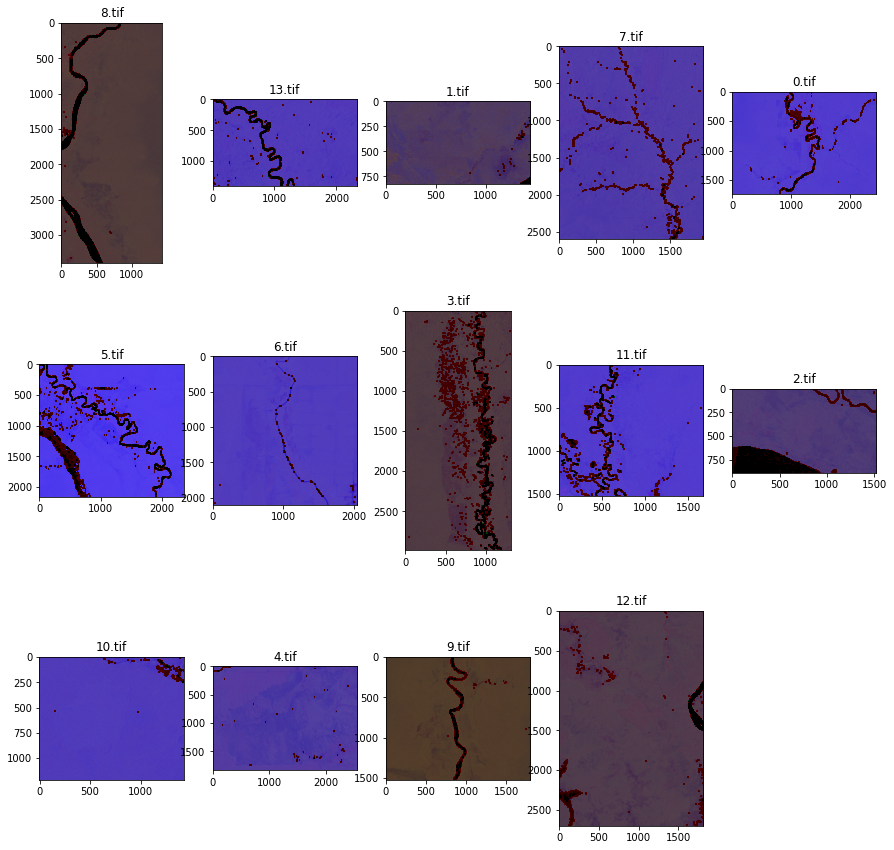

In [12]:
# Display all regions of latest acquisition
fig=plt.figure(figsize=(15, 15))
rows = 3
columns = 5
for i, f in enumerate(latest):
    img, y = load_numpy(f, 3)
    ## Add extra color
    img[:, :, 2] = img[:, :, 0] / img[:, :, 1]
    min = np.nanmin(img[:,:,2])
    max = np.nanmax(img[:,:,2])
    # Normalize
    img[:, :, 2] = (img[:, :, 2] - min) / (max - min)
    img[:, :, [0, 1]] = (img[:, :, [0, 1]] - - 30) / (40.3 - -30)
    
    x1 = fig.add_subplot(rows, columns, i + 1)
    x1.set_title(os.path.basename(f))
    plt.imshow(img)
plt.show()


## Show what the raw satellite images look like

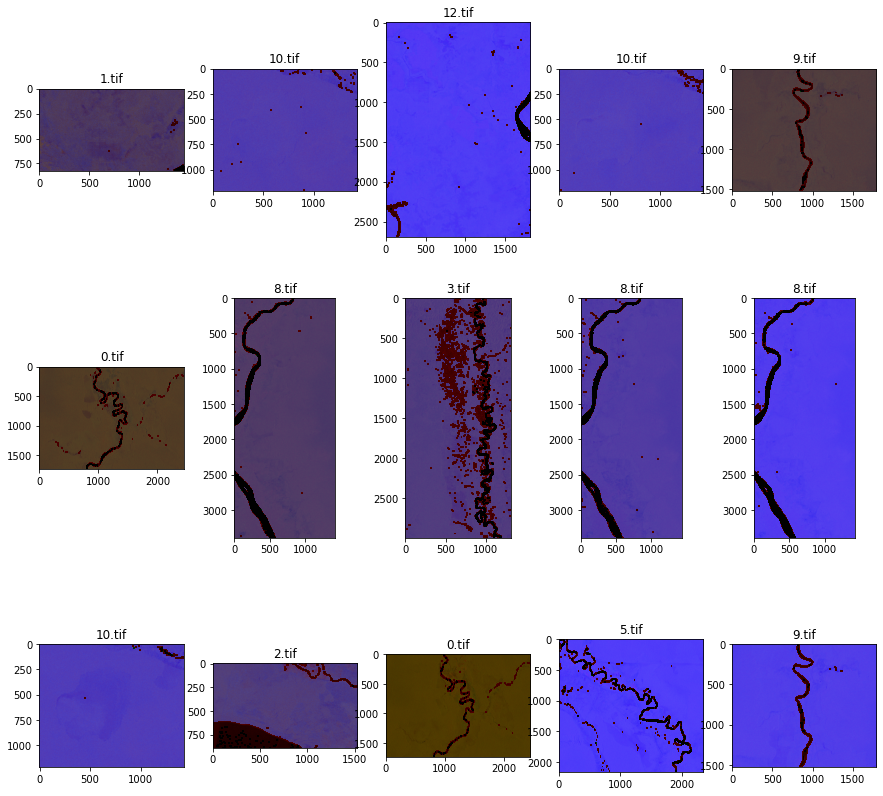

In [13]:
fig=plt.figure(figsize=(15, 15))
rows = 3
columns = 5
random.shuffle(files)
for i, f in enumerate(files[0:15]):
    img, y = load_numpy(f, 3)
    ## Add extra color
    img[:, :, 2] = img[:, :, 0] / img[:, :, 1]
    min = np.nanmin(img[:,:,2])
    max = np.nanmax(img[:,:,2])
    # Normalize
    img[:, :, 2] = (img[:, :, 2] - min) / (max - min)
    img[:, :, [0, 1]] = (img[:, :, [0, 1]] - - 30) / (40.3 - -30)
    
    x1 = fig.add_subplot(rows, columns, i + 1)
    x1.set_title(os.path.basename(f))
    plt.imshow(img)
plt.show()

## Get some random patches without transforming them

In [9]:
for i, f in enumerate(latest):
    x, y = load_numpy(f, 3)
    for i in range(10):
        img, labels = get_rand_patch(x, y, 320, False)
        nans = np.count_nonzero(np.isnan(img))
        nans_lbls = np.count_nonzero(np.isnan(labels))
        print("{}: IMAGE Nans: {} ({}%)".format(f, nans, (nans/img.size*100)))
        print("{}: LABEL Nans: {} ({}%)".format(f, nans_lbls, (nans_lbls/labels.size*100)))

# Seems like we're still on a relatively low nan count

data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 84 (0.027343750000000003%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 605 (0.19694010416666666%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/8.tif: IMAGE Nans: 53 (0.01725260416666666

data/003_1/2020_02_12/11.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 1 (0.00032552083333333337%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 206 (0.06705729166666667%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 260 (0.08463541666666667%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 246 (0.080078125%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 148 (0.048177083333333336%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 181 (0.058919270833333336%)
data/003_1/2020_02_12/11.tif: LABEL Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: IMAGE Nans: 0 (0.0%)
data/003_1/2020_02_12/11.tif: 

In [10]:
fig=plt.figure(figsize=(15, 15))
rows = 3
columns = 5
random.shuffle(files)
for i, f in enumerate(files[0:15]):
    x, y = load_numpy(f, 6, 3)
    img, labels = get_rand_patch(x, y, 320, False)
    img[:, :, 2] = img[:, :, 0] / img[:, :, 1]
    min = np.nanmin(img[:,:,2])
    max = np.nanmax(img[:,:,2])
    img[:, :, 2] = (img[:, :, 2] - min) / (max - min)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img)

plt.show()

TypeError: load_numpy() takes from 1 to 2 positional arguments but 3 were given

<Figure size 1080x1080 with 0 Axes>

In [ ]:
import random
files = glob("data/**/*.tif", recursive=True)
x = random.randint(0, 6)
test = range(x, x+3)
def is_test(file, test):
    return int(file.split("/")[-1].split(".")[0]) not in test
    
test_set = [f for f in files if is_test(f, test)]
val_set = [f for f in files if f not in test_set]
# Split train / test set
print(len(test_set), len(val_set))

In [ ]:
files = glob("data/003_2/2015_12_11/*.tif", recursive=True)
files.extend(glob("data/003_1/2015_10_24/*.tif"))
test = files[0]
size = {"x": 0, "y":0}
for f in files:
    rast = rasterio.open(f).read()
    size["x"] += rast.shape[1]
    size["y"] += rast.shape[2]
    
print("Mean width: ", size["x"] / len(files))
print("Mean height: ", size["y"] / len(files))

## Select data

In [20]:
files = glob("data/**/*.tif", recursive=True)
def get_year(f):
    split = f.split("/")
    date = [part for part in split if len(part) == 10][0]
    return int(date[0:4])

def get_location(f):
    split = f.split("/")
    return [part for part in split if len(part) == 5][0]

all_2018_up = [f for f in files if get_year(f) >= 2018]
year_2018_up_003_1 = [f for f in files if get_year(f) >= 2018 and get_location(f) == "003_1"]
all_years_003_1 = [f for f in files if get_location(f) == "003_1"]
sorted_files = sorted(year_2018_up_003_1)

In [24]:
len(files)

2526

### Get class distribution

In [27]:
from sys import getsizeof
from rasterio.errors import RasterioIOError

class_names = ["Forest", "Deforestation", "Degredation", "Non-forest", "Plantation", "Water"]
distribution = {
    "2015": {"pixels": 0, "labels": [0,0,0,0,0,0]},
    "2016": {"pixels": 0, "labels": [0,0,0,0,0,0]},
    "2017": {"pixels": 0, "labels": [0,0,0,0,0,0]},
    "2018": {"pixels": 0, "labels": [0,0,0,0,0,0]},
    "2019": {"pixels": 0, "labels": [0,0,0,0,0,0]},
    "2020": {"pixels": 0, "labels": [0,0,0,0,0,0]},
}

# files = sorted(glob("data/**/*.tif", recursive=True))
# files = all_years_003_1
# files = all_years_003_1
for year in distribution:
    files_in_year = [f for f in files if year in f]
    if len(files_in_year) == 0:
        continue
    last_date = files_in_year[-1].split("/")[2]
    for f in [f for f in files_in_year if last_date in f]:
        try:
            y = getLabelsForTIF(f)
            distribution[year]["pixels"] += y.shape[1] * y.shape[2]
            for l in range(len(class_names)):
                distribution[year]["labels"][l] += np.count_nonzero(y[l])
        except TypeError as e:
            print("Couldn't find labels for: ", f)

In [28]:
per_year = ["2015", "2016", "2017", "2018", "2019", "2020"]
pixels = 0
for year in per_year:
    print("{}: \n".format(year))
    for i in range(len(class_names)):
        name = class_names[i]
        coverage = distribution[year]["labels"][i]
        pixels = distribution[year]["pixels"]
        print("\t {}: {}".format(name, 0 if pixels == 0 else round(coverage / pixels * 100, 2)))

2015: 

	 Forest: 68.74
	 Deforestation: 1.36
	 Degredation: 0.01
	 Non-forest: 11.93
	 Plantation: 7.64
	 Water: 1.72
2016: 

	 Forest: 64.33
	 Deforestation: 5.62
	 Degredation: 0.15
	 Non-forest: 11.93
	 Plantation: 7.64
	 Water: 1.72
2017: 

	 Forest: 62.14
	 Deforestation: 7.59
	 Degredation: 0.37
	 Non-forest: 11.93
	 Plantation: 7.64
	 Water: 1.72
2018: 

	 Forest: 59.77
	 Deforestation: 9.87
	 Degredation: 0.46
	 Non-forest: 11.93
	 Plantation: 7.64
	 Water: 1.72
2019: 

	 Forest: 57.87
	 Deforestation: 11.66
	 Degredation: 0.58
	 Non-forest: 11.93
	 Plantation: 7.64
	 Water: 1.72
2020: 

	 Forest: 54.42
	 Deforestation: 15.34
	 Degredation: 0.34
	 Non-forest: 11.93
	 Plantation: 7.64
	 Water: 1.72


## Compare created labels to actual labels (make sure everything went correct)

In [ ]:
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import pandas as pd
from PIL import Image
init_notebook_mode(connected=False)

In [ ]:
color_mapping = {
    1: [51, 160, 44],
    0: [255, 255, 255],
}

def map_colors(labels):
    shape = labels.shape
    result = list()
    for x in labels.flatten():
        result.append(color_mapping.get(x, [255, 255, 255]))
    return np.uint8(np.array(result).reshape(shape[0], shape[1], 3))

img = map_colors(labels[0])
img_true = map_colors(deforest)

In [ ]:
Image.fromarray(img)

In [ ]:
Image.fromarray(img_true)

## Build TensorFlow TFRecords

In [ ]:
def load_file(file):
    x, y = load_numpy(file)
    if x is None or y is None:
        return None, None
    x = np.concatenate((x, y[:,:,[0,3,4,5]]), axis=2)
    return x, y[:, :, [1]]

x, y = load_file(all_years_003_1[0])

In [ ]:
fig=plt.figure(figsize=(10, 10))

plt.imshow(norm_img(x[:, :, 0:3]))

plt.show()

In [ ]:
with tf.io.TFRecordWriter("tfrecords/test_image_segmentation.tfrecords") as writer:
    image_bytes = tf.io.serialize_tensor(x)
    labels_bytes = tf.io.serialize_tensor(y)

    example = serialize_data(image_bytes, labels_bytes, x.shape, y.shape)
    writer.write(example)

In [ ]:
dataset = tf.data.TFRecordDataset("tfrecords/test_image_segmentation.tfrecords").map(read_tfrecord)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=10)
for data, labels in dataset.take(1):
    print(data.shape)

In [ ]:
from tf_records_generator import create_tfrecords

create_tfrecords(year_2018_up_003_1, total_samples=4000, patch_sz=240, tfrecord_dir="tfrecords/003_1_2018_240ps_1class/float32/")

In [ ]:
dataset = tf.data.TFRecordDataset(glob("tfrecords/003_1_2018_160ps_1class/float32/*.tfrecords")).map(read_tfrecord)
x = None
for data, labels in dataset.take(1):
    print(data.shape)
    print(labels.shape)

## Do the same for Center Image prediction TFRecords

In [ ]:
xs, ys = get_rand_patches_1pp(x, y, sz=301, n_patches=10, transform=False)

In [ ]:
def serialize_data(image, labels, image_shape, labels_shape):
    feature = {
        'image': _bytes_feature(image),
        'labels': _int64_feature((int)(labels)) if labels_shape is None else _bytes_feature(labels),
        'width': _int64_feature(image_shape[0]),
        'height': _int64_feature(image_shape[1]),
        'n_bands': _int64_feature(image_shape[2]),
        'n_classes': _int64_feature(1 if labels_shape is None else labels_shape[2])
    }  # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()



with tf.io.TFRecordWriter("tfrecords/test_center_prediction.tfrecords") as writer:
    x = xs[0]
    y = ys[0]
    print(x.shape)
    image_bytes = tf.io.serialize_tensor(x)
    data = serialize_data(image_bytes, y, x.shape, None)
    writer.write(data)

In [ ]:
def read_tfrecord_center_pixel(serialized_record):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'n_bands': tf.io.FixedLenFeature([], tf.int64),
        'n_classes': tf.io.FixedLenFeature([], tf.int64)
    }
    record = tf.io.parse_single_example(serialized_record, feature_description)

    image = tf.io.parse_tensor(record['image'], out_type=tf.float32)
    image_shape = [record['width'], record['height'], record['n_bands']]
    image = tf.reshape(image, image_shape)
    labels = record['labels']
    return image, labels

dataset = tf.data.TFRecordDataset("tfrecords/test_center_prediction.tfrecords").map(read_tfrecord_center_pixel)
for data, labels in dataset.take(1):
    print("Input shape: ", data.shape)
    print("Labels: ", labels.numpy())

In [ ]:
from tf_records_generator import create_tfrecords

create_tfrecords(year_2018_up_003_1, total_samples=4000, patch_sz=161,
                 patches_per_file=10, center_pixel_prediction=True,
                 tfrecord_dir="tfrecords/center_pixel/003_1_2018_161ps_all_context/float32/")

## T + 1 inspection

In [ ]:
def get_date(f):
    return f.split("/")[2]

def get_region(f):
    return "/" + f.split("/")[-1]

def get_next_file(f, files, steps=3):
    d = get_date(f)
    r = get_region(f)
    dates = sorted(set(map(get_date, files)))
    newDate = dates[dates.index(d) + steps]
    nextFiles = [f for f in files if newDate in f and r in f]
    return nextFiles[0] if len(nextFiles) > 0 else None

def load_file(file):
    x, y = load_numpy(file)
    if x is None or y is None:
        return None, None
    x = np.concatenate((x, y[:, :, [0, 3, 4, 5]]), axis=2)  # Test with adding the context to the images
    return x, y[:, :, [1]]


test_file = "data/003_1/2019_08_16/0.tif"
next_file = get_next_file(test_file, year_2018_up_003_1)
print(test_file)
print(next_file)

In [ ]:

sz = 160
padding = math.ceil(sz / 2)
print(padding)
y = getLabelsForTIF(test_file).transpose([1, 2, 0])[:, :, [1]]
yt1 = getLabelsForTIF(next_file).transpose([1, 2, 0])[:, :, [1]]

feasible_y = y[padding:y.shape[0] - padding, padding:y.shape[1] - padding]
feasible_y1 = yt1[padding:yt1.shape[0] - padding, padding:yt1.shape[1] - padding]
print(feasible_y.shape)
print(feasible_y1.shape)

In [ ]:
merged = np.concatenate((feasible_y, feasible_y1), axis=2)

In [ ]:
indexes = np.array(np.where(merged[:,:,0] - merged[:,:,1] == -1)).transpose([1, 0])

In [ ]:
len(indexes)

In [ ]:
indices = random.choices(range(0, len(indexes)), k=10)
for i in range(10):
    indice = indices[i]
    print(indexes[indice])

# Create TF_Records for files

In [30]:
from tf_records_generator import create_tfrecords

create_tfrecords(all_2018_up, total_samples=10000, patch_sz=31,
                 patches_per_file=10, center_pixel_prediction=True, t_steps=4,
                 tfrecord_dir="tfrecords/center_pixel_t1/2018_31ps_all_context/float32/")